In [1]:
import os, shutil
import tensorflow as tf

In [2]:
original_dataset_dir = '/floyd/input/skin_disease_dataset/train'


In [3]:
os.listdir('/floyd/input/skin_disease_dataset/train')

['Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Exanthems and Drug Eruptions',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Vascular Tumors',
 'Urticaria Hives',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Nail Fungus and other Nail Disease',
 'Warts Molluscum and other Viral Infections',
 'Acne and Rosacea Photos',
 'Atopic Dermatitis Photos',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Vasculitis Photos',
 'Bullous Disease Photos',
 'Herpes HPV and other STDs Photos',
 'Melanoma Skin Cancer Nevi and Moles',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Scabies Lyme Disease and other Infestations and Bites']

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications.vgg16 import  preprocess_input
# from tf.keras.applications.res import  preprocess_input
img_width, img_height = 224, 224

In [5]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = preprocess_input(a)
    return a

In [6]:
res = preprocess_image("/floyd/input/skin_disease_dataset/train/Acne and Rosacea Photos/07Acne081101.jpg")
print(res)

[[[[   8.060997     4.2210007   31.32     ]
   [  15.060997     8.221001    36.32     ]
   [  18.060997     9.221001    37.32     ]
   ...
   [   2.060997    -3.7789993   28.32     ]
   [   5.060997    -0.7789993   31.32     ]
   [   4.060997    -1.7789993   30.32     ]]

  [[  15.060997    11.221001    38.32     ]
   [  18.060997    11.221001    39.32     ]
   [  20.060997    11.221001    39.32     ]
   ...
   [ -13.939003   -19.779       12.32     ]
   [   9.060997     1.2210007   33.32     ]
   [  17.060997    10.221001    40.32     ]]

  [[  13.060997     9.221001    36.32     ]
   [  13.060997     6.2210007   34.32     ]
   [  17.060997     8.221001    36.32     ]
   ...
   [  19.060997    11.221001    43.32     ]
   [  22.060997    12.221001    43.32     ]
   [   7.060997    -2.7789993   28.32     ]]

  ...

  [[   7.060997     3.2210007   33.32     ]
   [   8.060997     4.2210007   31.32     ]
   [  21.060997    13.221001    39.32     ]
   ...
   [-100.939     -110.779     -113.

In [7]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

HEIGHT = 224
WIDTH = 224

base_model = EfficientNetB7(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))


258080768/258076736 [==============================] - 4s 0us/step


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/floyd/input/skin_disease_dataset/train"
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        '/floyd/input/skin_disease_dataset/test',
        target_size=(224, 224),
        batch_size=BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [9]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = os.listdir("/floyd/input/skin_disease_dataset/train")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


NUM_EPOCHS = 200
BATCH_SIZE = 20
num_train_images = 15557

adam = tf.keras.optimizers.Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(
    k=5, name='top_5'), tf.keras.metrics.TopKCategoricalAccuracy(
    k=3, name='top_3')])


checkpoint = ModelCheckpoint('efficientNet.h5', monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history1 = finetune_model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=(validation_generator),
                             workers=16, 
                             steps_per_epoch=num_train_images // BATCH_SIZE,
                             validation_steps = num_train_images // BATCH_SIZE, shuffle=True, callbacks=callbacks_list)


Epoch 1/200
777/777 [==============================] - 206s 113ms/step - loss: 3.2416 - accuracy: 0.1092 - top_5: 0.3747 - top_3: 0.2604 - val_loss: 2.6806 - val_accuracy: 0.2296 - val_top_5: 0.5630 - val_top_3: 0.4378

Epoch 00001: saving model to efficientNet.h5
Epoch 2/200
777/777 [==============================] - 83s 106ms/step - loss: 2.8583 - accuracy: 0.1799 - top_5: 0.4699 - top_3: 0.3519 - val_loss: 2.6435 - val_accuracy: 0.2369 - val_top_5: 0.5778 - val_top_3: 0.4533

Epoch 00002: saving model to efficientNet.h5
Epoch 3/200
777/777 [==============================] - 83s 107ms/step - loss: 2.8095 - accuracy: 0.1959 - top_5: 0.5030 - top_3: 0.3815 - val_loss: 2.5867 - val_accuracy: 0.2564 - val_top_5: 0.5919 - val_top_3: 0.4639

Epoch 00003: saving model to efficientNet.h5
Epoch 4/200
777/777 [==============================] - 83s 106ms/step - loss: 2.7701 - accuracy: 0.2042 - top_5: 0.4989 - top_3: 0.3861 - val_loss: 2.5325 - val_accuracy: 0.2671 - val_top_5: 0.6155 - val_top

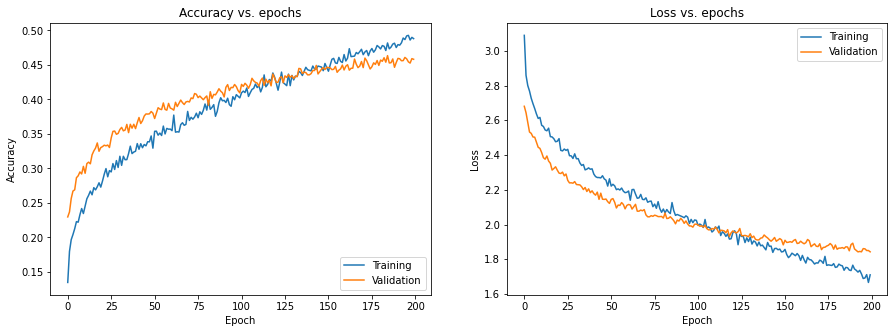

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
except KeyError:
    plt.plot(history1.history['acc'])
    plt.plot(history1.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = finetune_model.predict_generator(validation_generator, num_train_images // 31)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
matrix = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Urticaria Hives', 'Seborrheic Keratoses and other Benign Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Acne and Rosacea Photos', 'Vascular Tumors', 'Eczema Photos', 'Psoriasis pictures Lichen Planus and related diseases', 'Exanthems and Drug Eruptions', 'Lupus and other Connective Tissue diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Bullous Disease Photos', 'Nail Fungus and other Nail Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Systemic Disease', 'Light Diseases and Disorders of Pigmentation', 'Atopic Dermatitis Photos', 'Warts Molluscum and other Viral Infections', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')